# Checkout radiometrics features 

In the first step I would like to check the format of radiometric features we get from the pyradiomics library. I would like to see, whether we have only quantitative variables for example and do some first checks for correlations between features. 

As we have a pretty small dataset here, I would want to carefully select relevant features to avoid overfitting any model to such limited amount of data. Also, as a classifier, I would use something topology or geometry based model, like decisionForests, lasso, many some linear models etc. Otherwise, the chance of overfitting is pretty high here.

Lets start with getting the features from all of the samples we have available.

In [1]:
# List files and pair with masks

import os

dir_names = ["data/images/","data/masks/"]

# first the images
image_filenames = []
for path in os.listdir(dir_names[0]):
    if(os.path.isfile(os.path.join(dir_names[0], path))):
        image_filenames.append(path) # we only want the filename, as they are the same for images and masks folder
        
# check, whether we have matching masks for each image in the masks folder

missing_mask = False

#just iterate through every filename in the image_filenames list and check whether it exists in the mask folder
for filename in image_filenames:
    if(not os.path.isfile(os.path.join(dir_names[1], filename))):
        missing_mask = True # when one is missing, set this bool to True
        
assert missing_mask == False, "images and mask files not matching!"

In [2]:
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor
import pandas as pd

# these are the standard settings, may need some tunning with more information about the data we have
# would ask an expert at this point to provide better settings 

settings = {}
settings['binWidth'] = 25
settings['resampledPixelSpacing'] = None  # [3,3,3] is an example for defining resampling (voxels with size 3x3x3mm)
settings['interpolator'] = sitk.sitkBSpline



# Initialize feature extractor
radiomics_feature_extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

radiomics_feature_extractor.disableAllFeatures()

# these are the feature class names for the radiomics lib to enable feature extraction from these specific classes
# lets get all of the features avaiable and then later filter them by importance and select
feature_class_names = ["firstorder","shape2D","glcm","glrlm","glszm","gldm","ngtdm"]


# Enable all features in firstorder
for feature_class_name in feature_class_names:
    radiomics_feature_extractor.enableFeatureClassByName(feature_class_name)
    
    
# lets get the first sample and see what output we get from the extractor
extracted_features = radiomics_feature_extractor.execute("data/images/1_bonel1.nrrd","data/masks/1_bonel1.nrrd")
# for better reading
for feature_key in extracted_features.keys():
    print(feature_key,":",extracted_features[feature_key])

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


diagnostics_Versions_PyRadiomics : v3.0.1
diagnostics_Versions_Numpy : 1.24.2
diagnostics_Versions_SimpleITK : 2.2.1
diagnostics_Versions_PyWavelet : 1.4.1
diagnostics_Versions_Python : 3.10.6
diagnostics_Configuration_Settings : {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 23, 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25}
diagnostics_Configuration_EnabledImageTypes : {'Original': {}}
diagnostics_Image-original_Hash : 41ad1ac43d1bca70c05eb715c0c40bd43b48b597
diagnostics_Image-original_Dimensionality : 2D
diagnostics_Image-original_Spacing : (1.0, 1.0)
diagnostics_Image-original_Size : (15, 15)
diagnostics_Image-original_Mean : 231.70220302960254
diagnostics_Image-original_Minimum : 0.0
diagnostics_Image-original_Maximum : 783.8122414819543
diagno

It looks like we have quantitative variables only. Also, to filter the frame, we can see, that the acctual features start with an "original_" in the key name. I want to convert these to a pandas Dataframe and check the correlation between features, which might be interesting for feature selection later on.

In [3]:
dataframe_column_names = [] #create column names for our dataframe
class_names = ["bone","kidney","liver","muscle","spleen"]



for feature_key in extracted_features.keys():
    if(feature_key.split("_")[0]=="original"):
        dataframe_column_names.append(feature_key)
        
dataframe_column_names.append("className") #append classname column into the frame 
dataframe_column_names.append("class") #append class (int) column into the frame 


# create raw dataframe with columns
data_frame = pd.DataFrame(columns=dataframe_column_names)

# fill frame with all data 

for filename in image_filenames:
    absolute_filenames = [dir_names[i]+filename for i in range(2)] # absolute filenames for images and masks
    
    raw_feature_vector = radiomics_feature_extractor.execute(absolute_filenames[0],absolute_filenames[1])    
    
    #filter the feature vector so we get a dict with only features and drop the extra info
    filtered_feature_vector = {}
    for feature_key in raw_feature_vector.keys():
        if(feature_key.split("_")[0]=="original"): 
            filtered_feature_vector[feature_key] = float(raw_feature_vector[feature_key])
            
    #get the class from the filename
    for j,class_name in enumerate(class_names):
        if(class_name in absolute_filenames[0]): 
            filtered_feature_vector["className"] = class_name
            filtered_feature_vector["class"] = j
            
    data_frame = data_frame.append(filtered_feature_vector,ignore_index=True)
            


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_256386/2591409411.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(filtered_feature_vector,ignore_index=True)
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_256386/2591409411.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(filtered_feature_vector,ignore_index=True)
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_256386/2591409411.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(filtered_featu

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_256386/2591409411.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(filtered_feature_vector,ignore_index=True)
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_256386/2591409411.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(filtered_feature_vector,ignore_index=True)
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_256386/2591409411.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(filtered_featu

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_256386/2591409411.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(filtered_feature_vector,ignore_index=True)
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_256386/2591409411.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(filtered_feature_vector,ignore_index=True)
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
/tmp/ipykernel_256386/2591409411.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(filtered_featu

In [4]:
# lets see how it looks like and if everything went well
data_frame.head()

,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile,...,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,className,class
0,0.974278,13.618061,14.317821,141.5,13.267774,44.627417,0.315388,142.0,0.944890,827.079845,...,0.793036,571.404930,0.013447,0.018534,0.058793,3923.746786,0.707885,49.336586,muscle,3
1,0.999289,13.548268,14.142136,143.5,13.538639,45.455844,0.316765,144.0,0.934203,605.661462,...,0.767361,674.076389,0.005889,0.016865,0.056586,3785.541326,0.538583,65.743619,liver,2
2,0.960040,13.809970,14.317821,143.5,13.258121,44.627417,0.310992,144.0,0.951545,0.000000,...,0.559907,101.101573,0.055484,1.139018,0.009828,1947.185257,0.851824,14.100444,bone,0
3,0.988395,13.430972,14.142136,139.5,13.275111,44.627417,0.319910,140.0,0.938189,0.000000,...,0.690868,315.869439,0.017260,0.080783,0.025510,3163.924077,0.698681,40.797137,bone,0
4,0.999273,13.389951,13.928388,140.5,13.380210,43.798990,0.311737,141.0,0.959354,0.000000,...,0.694597,154.786796,0.038242,0.151032,0.027410,1540.354204,0.579545,17.021089,bone,0


In [5]:
# now lets visualize the correlations between variables. Drop class and classname here
correlation_dataframe = data_frame.drop(columns=["class","className"])
feature_correlation = correlation_dataframe.corr()
feature_correlation

,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,original_firstorder_10Percentile,...,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
original_shape2D_Elongation,1.000000,-0.584927,-0.519746,-0.046310,0.507855,-0.272766,-0.275959,-0.046310,0.382439,0.057770,...,0.018212,0.005698,-0.183164,-0.151020,-0.006630,-0.055911,-0.026094,-0.106184,-0.086735,-0.157776
original_shape2D_MajorAxisLength,-0.584927,1.000000,0.915853,0.836856,0.401548,0.801007,-0.319279,0.836856,-0.433621,-0.003389,...,-0.087821,-0.071027,-0.086617,-0.063269,-0.074285,0.028162,0.186651,-0.131814,-0.185567,-0.018819
original_shape2D_MaximumDiameter,-0.519746,0.915853,1.000000,0.775534,0.388414,0.728477,-0.310708,0.775534,-0.381520,0.058796,...,-0.118007,-0.113450,-0.023977,-0.042152,-0.134184,-0.029295,0.206070,-0.119030,-0.178019,-0.013967
original_shape2D_MeshSurface,-0.046310,0.836856,0.775534,1.000000,0.836313,0.786482,-0.601172,1.000000,-0.250285,0.039946,...,-0.096089,-0.083491,-0.227103,-0.177045,-0.092867,-0.001348,0.214522,-0.231817,-0.285713,-0.127276
original_shape2D_MinorAxisLength,0.507855,0.401548,0.388414,0.836313,1.000000,0.543629,-0.649117,0.836313,-0.030371,0.062638,...,-0.074644,-0.071394,-0.297272,-0.234983,-0.089375,-0.034812,0.169540,-0.258026,-0.295080,-0.196735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
original_ngtdm_Busyness,-0.055911,0.028162,-0.029295,-0.001348,-0.034812,0.023848,0.030618,-0.001348,-0.038588,-0.412996,...,0.802657,0.856349,-0.472733,-0.251823,0.636270,1.000000,-0.584124,-0.104086,0.210663,-0.212857
original_ngtdm_Coarseness,-0.026094,0.186651,0.206070,0.214522,0.169540,0.090629,-0.229881,0.214522,0.067867,0.739364,...,-0.698437,-0.775842,0.054084,0.075094,-0.642279,-0.584124,1.000000,-0.226516,-0.615804,0.104098
original_ngtdm_Complexity,-0.106184,-0.131814,-0.119030,-0.231817,-0.258026,-0.180473,0.144655,-0.231817,0.054452,-0.123651,...,0.002293,0.016458,0.501919,0.835558,-0.053963,-0.104086,-0.226516,1.000000,0.814691,0.879678
original_ngtdm_Contrast,-0.086735,-0.185567,-0.178019,-0.285713,-0.295080,-0.199022,0.207050,-0.285713,0.030728,-0.400247,...,0.342236,0.419274,0.423869,0.532509,0.340182,0.210663,-0.615804,0.814691,1.000000,0.566142


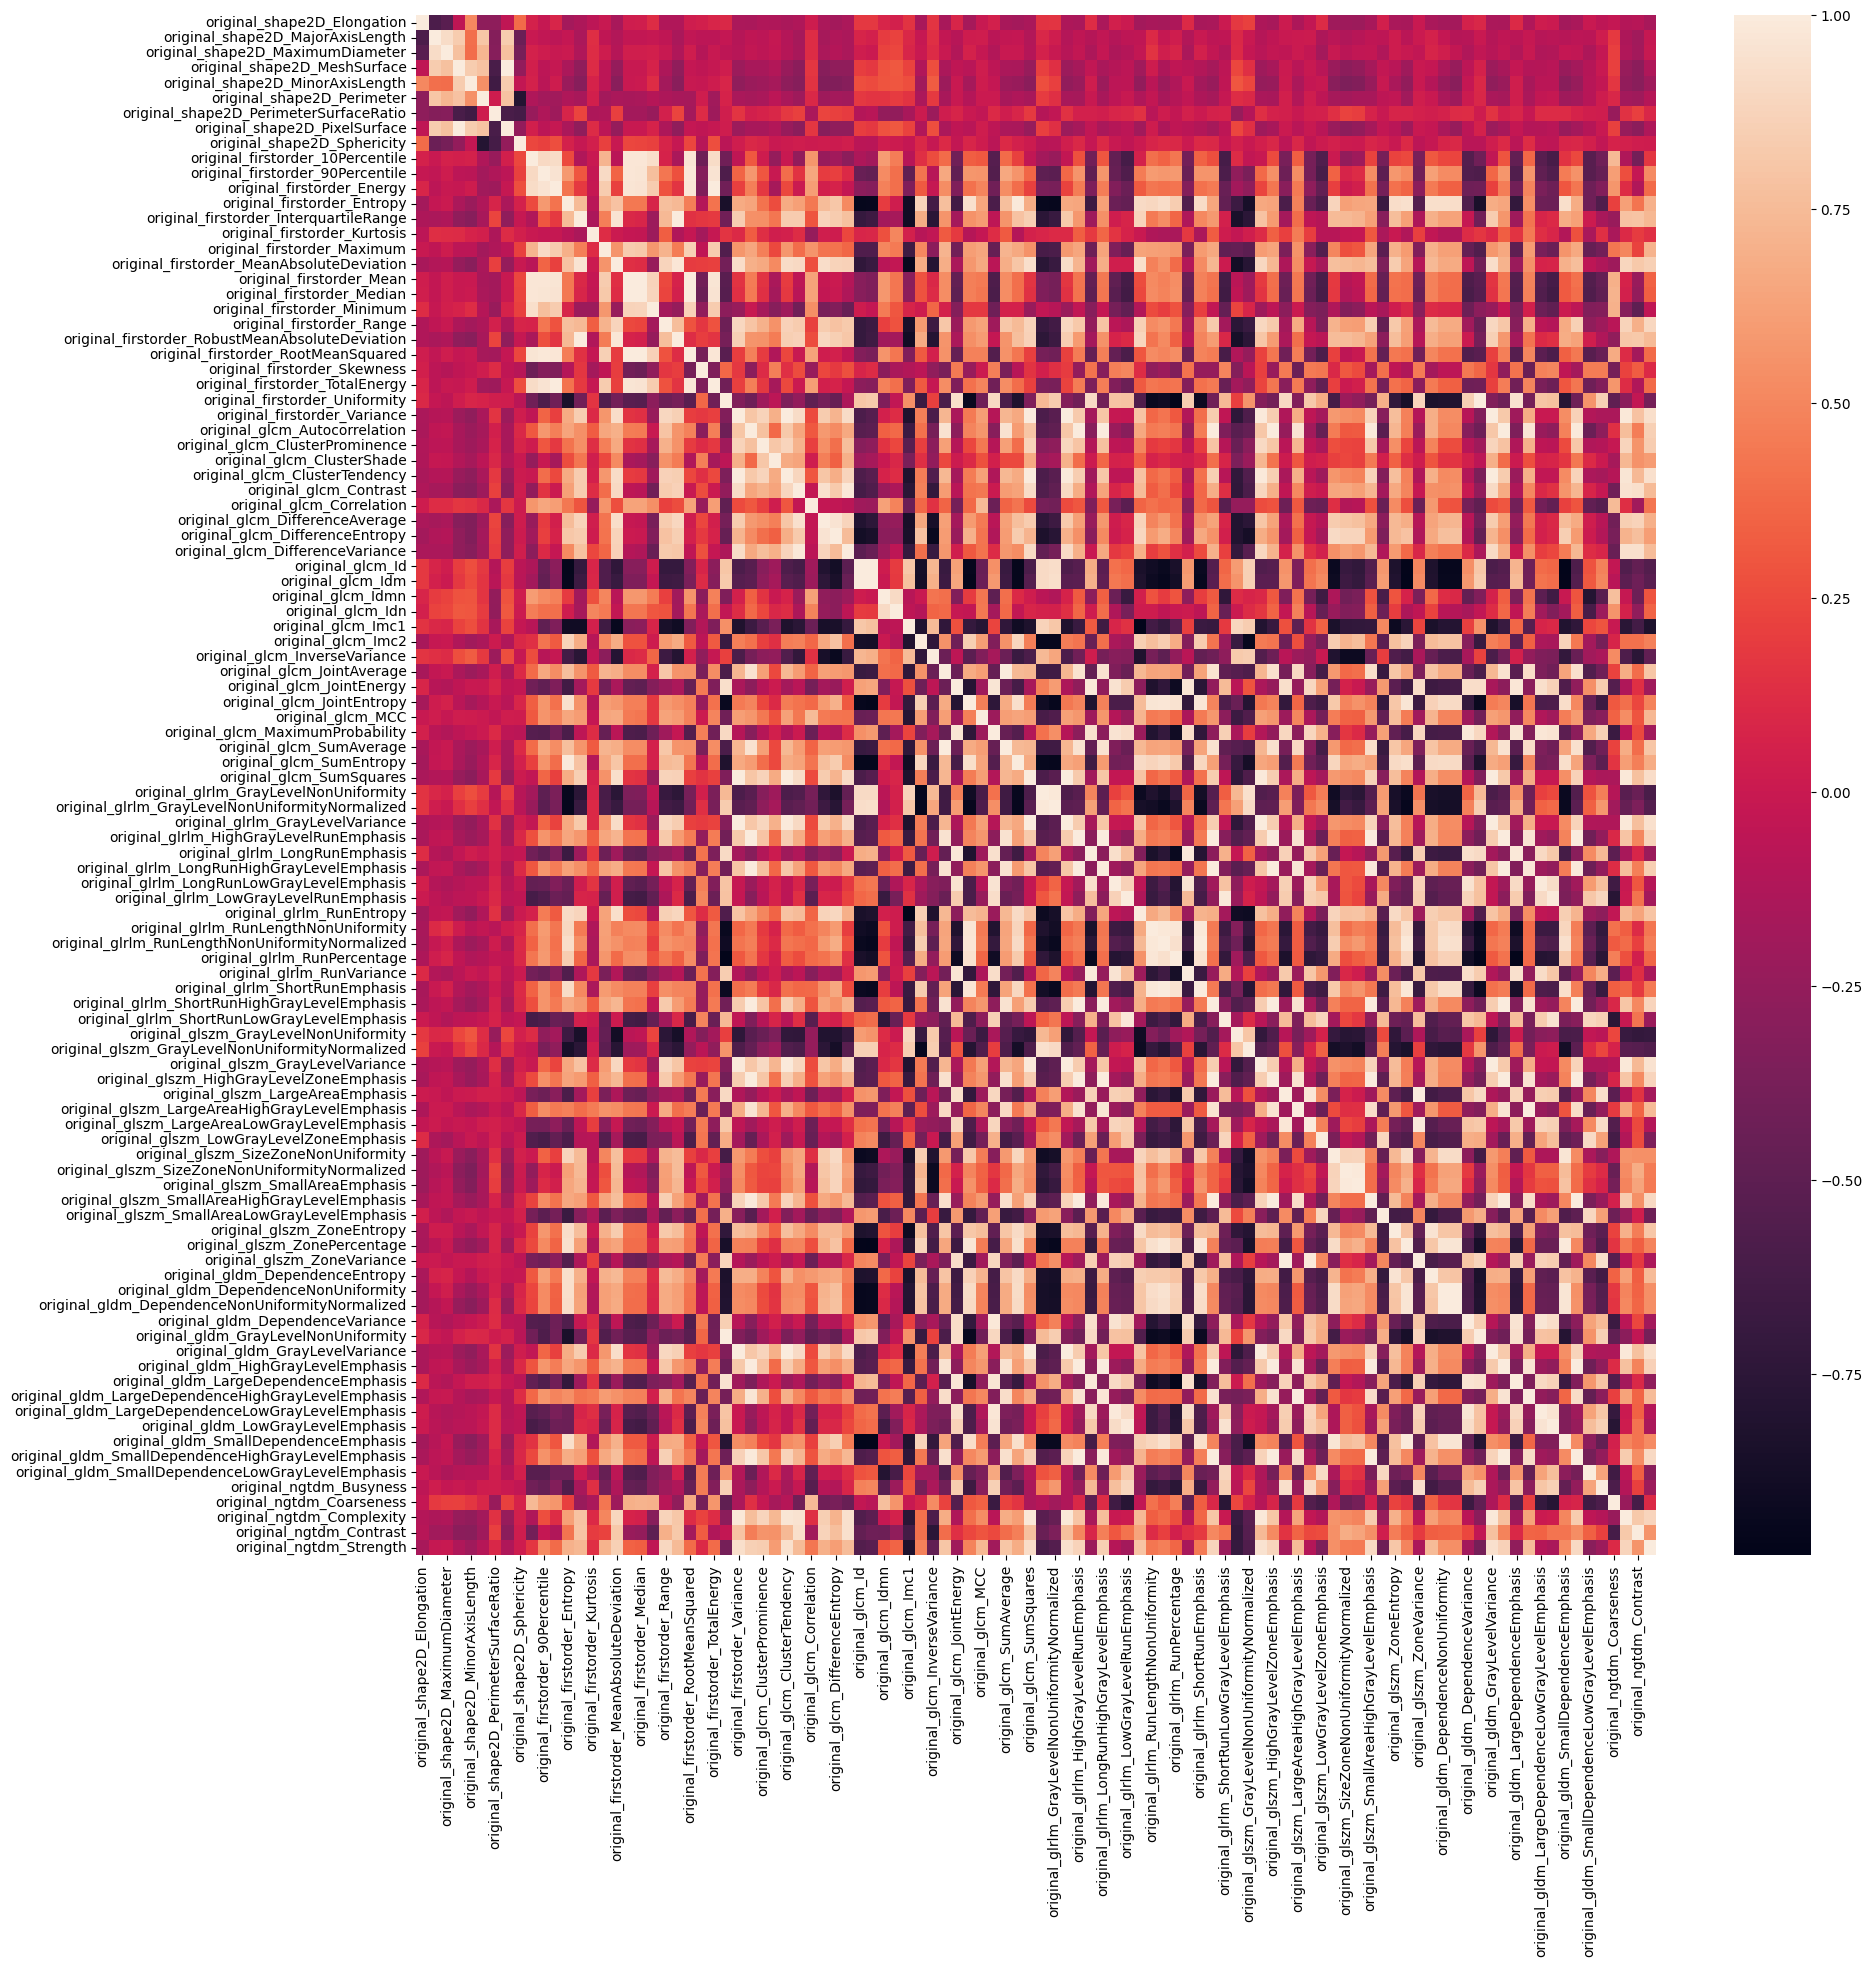

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sns.heatmap(feature_correlation)
plt.show()

We can see many correlations between variables, so we can assume, that a great part of features hold no additional information for the prediction. In the next step I always love to use a dimensionality reduction tool to visualize clusters for known classes. Its a nice way to check, whether the available features hold enough information to acctually cluster datapoints and make them separable against other classes in general. If we would have uncorrelated features to the class prediction here, we would see no separability for a tool like tSNE. Therefore, lets use tSNE here to check quickly, if the predictive power of our features so far is acctually given.


[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 66 samples in 0.001s...
[t-SNE] Computed neighbors for 66 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 66 / 66
[t-SNE] Mean sigma: 44783138.997653
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.310612
[t-SNE] KL divergence after 800 iterations: 0.062647


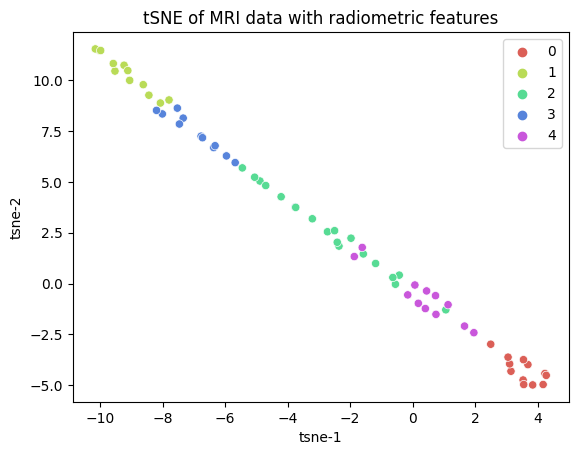

In [7]:
import numpy as np

# we need raw samples*feature and samples shaped vectors as input for tsne

set_x = correlation_dataframe.to_numpy() #take the previous frame with only the feature variables
set_y = data_frame["class"].to_numpy(dtype=np.uint8)

# do some tSNE magic

from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, verbose=1, random_state=123,perplexity=16,n_iter=10000) #checked some perplexity settings here for better visualization
tsne_z = tsne.fit_transform(set_x) 

tsne_dataframe = pd.DataFrame()
tsne_dataframe["class"] = set_y
tsne_dataframe["tsne-1"] = tsne_z[:,0]
tsne_dataframe["tsne-2"] = tsne_z[:,1]

plt.figure()
sns.scatterplot(x="tsne-1", y="tsne-2", hue=tsne_dataframe["class"].tolist(),
                palette=sns.color_palette("hls", 5),
                data=tsne_dataframe).set(title="tSNE of MRI data with radiometric features") 
plt.show()

Very good! We could separate the classes pretty well from the tSNE transformation of our feature space into tsne. This means we got some very good features here with almost perfect predictive power. 

So lets go on with some feature importance calculations. There are many methods for this, I prefer using decision trees, or more precisely random forest ensemble as a base estimator. We will take a bigger amount of estimators aka. trees to have a better estimation over many, randomly selected feature subsets. With the ensemble, we also have a better chance to avoid overfitting, as we take advantage of the bagging methode used for the ensemble.

I would directly combine the estimator with a recursive feature elimination method to also select the best amount of features to score a good accuracy. 
To further enhance the method, I introduce some cross-validation to further regularize feature importance computation of the base estimator to not overfit to a specific part of the train data. We can directly get the CV score as the measure for fitness of the estimator with n selected, important features.

I modified the next code to already do all the computations of RFE with cross-validation and also using different base estimators, which can estimate feature importance.

We can then select the best model based on the best mean CV score of the best estimator

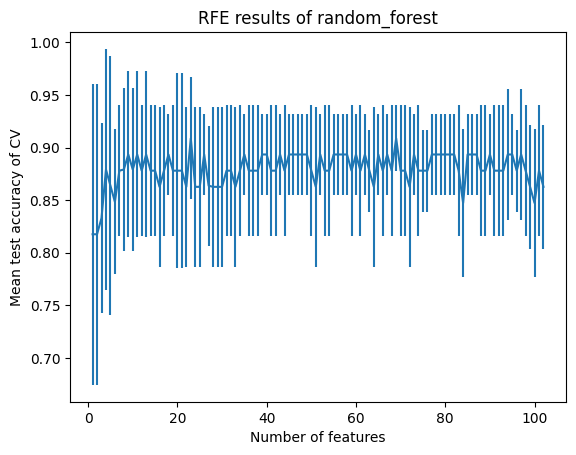

Optimal feature count: 69
Mean accuracy of best estimator with CV: 0.9087912087912089


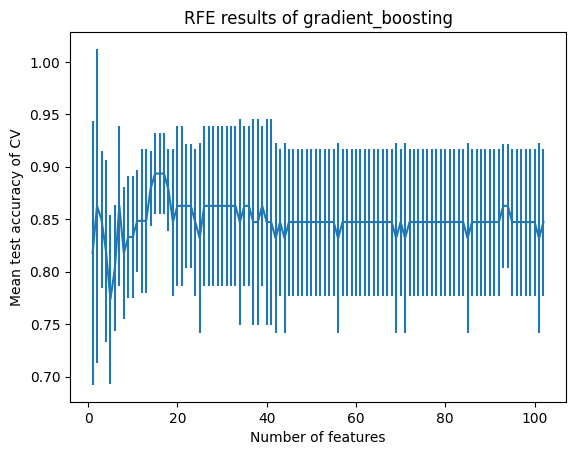

Optimal feature count: 15
Mean accuracy of best estimator with CV: 0.8934065934065935


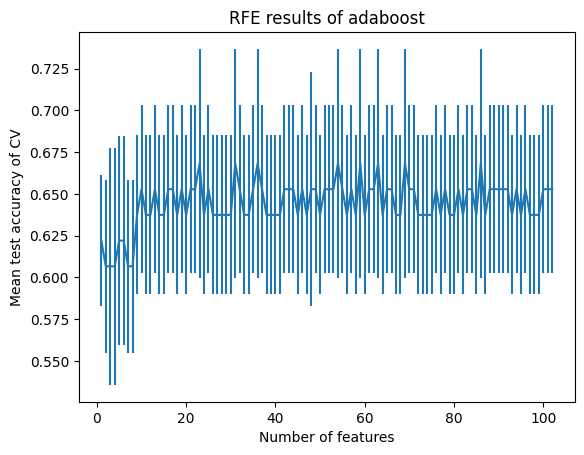

Optimal feature count: 23
Mean accuracy of best estimator with CV: 0.6681318681318682


In [8]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier

base_estimators = {"random_forest" : RandomForestClassifier(),
                   "gradient_boosting":GradientBoostingClassifier(),
                   "adaboost":AdaBoostClassifier()
                   }

for estimator_key in base_estimators.keys():

    min_feature_amount = 1  
    base_estimator = base_estimators[estimator_key]


    cv_method = StratifiedKFold(5) #lets do 5 splits, which is default

    rfecv_estimator = RFECV(
        estimator=base_estimator,
        step=1,
        cv=cv_method,
        scoring="accuracy",
        min_features_to_select=min_feature_amount,
        n_jobs=16
    )
    # fit whole set
    rfecv_estimator.fit(set_x, set_y)
    
    
    # display the result of feature elimination with error bars and best feature count

    n_scores = len(rfecv_estimator.cv_results_["mean_test_score"])

    plt.figure()
    plt.xlabel("Number of features")
    plt.ylabel("Mean test accuracy of CV")
    plt.errorbar(
        range(min_feature_amount, n_scores + min_feature_amount),
        rfecv_estimator.cv_results_["mean_test_score"],
        yerr=rfecv_estimator.cv_results_["std_test_score"],
    )
    plt.title(f'RFE results of {estimator_key}')
    plt.show()

    print("Optimal feature count:",rfecv_estimator.n_features_)
    print("Mean accuracy of best estimator with CV:",rfecv_estimator.cv_results_["mean_test_score"][rfecv_estimator.n_features_-min_feature_amount])


As we can see, the random forest ensemble performs the best in our task. Whats interesting to see is as well, that the peak of information for both boosting techiques is reached at around 17 features. This is a good result to see an overall "alignment" of feature importance count for every method used. Thes results make also sense, as boosting is prone to overfitting and thus gets instable with a small amount of data. Therefore, the bagging approach with the random forest seems to be the best here.
Also, we can read out the high correlation between features, as the mean test error saturates and stays almost the same here. We have a high increase of test accuracy after just 5-6 features for all classifier methods. 
Therefore, we can conclude, that acctually taking around 10 features here would be the best choice, as the results are noisy to its stochastic calculation nature. 

Lets calculate the RFE again with random forest and 10 fixed features over a CV with more reps

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE

rfe_estimator = RFE(estimator=RandomForestClassifier(), n_features_to_select=10) #select the 10 features
cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=123) #do 5 splits and repeat 10 times for better estimation
scores = cross_val_score(rfe_estimator, set_x, set_y, scoring='accuracy', cv=cv_method, n_jobs=-1)

In [10]:
print("mean:",np.mean(scores)," std:", np.std(scores))

mean: 0.8894505494505494  std: 0.07943800913298797


At this point, we can display the selected features 

In [11]:
rfe_estimator.fit(set_x,set_y) #fit RFE estimator and display selected features

for idx,value in enumerate(rfe_estimator.get_support(True)):
    print("feature ",correlation_dataframe.columns[value])

feature  original_firstorder_10Percentile
feature  original_firstorder_90Percentile
feature  original_firstorder_Energy
feature  original_firstorder_Maximum
feature  original_firstorder_Mean
feature  original_firstorder_Median
feature  original_firstorder_RootMeanSquared
feature  original_firstorder_TotalEnergy
feature  original_glcm_Contrast
feature  original_glcm_DifferenceEntropy


These are the features, which are the best for solving our classification problem. Lets transform our dataset with the RFE model to the reduced feature set and optimize the RandomForestClassifier with a grid search and evaluate over CV mean test error

In [12]:
reduced_set_x = rfe_estimator.transform(set_x) #reduced feature set



from sklearn.model_selection import GridSearchCV

grid_param = {'n_estimators': [5, 10, 15, 20, 50, 80, 100],
              'max_depth': [2, 5, 7, 9, 11, 13, 15, 17]
             }

base_estimator = RandomForestClassifier() #base estimator still random forest
cv_method = StratifiedKFold(5) #cv method

grid_estimator = GridSearchCV(base_estimator, grid_param, cv=cv_method,verbose=2)
grid_estimator.fit(reduced_set_x, set_y)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=2, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=15; total time=   0.0s
[CV] END .......................max_depth=2, n_

[CV] END ......................max_depth=7, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=7, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=7, n_estimators=100; total time=   0.1s
[CV] END ........................max_depth=9, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=9, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=9, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=9, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=9, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=9, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=9, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=9, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=9, n_estimators=10; total time=   0.0s
[CV] END ...................

[CV] END ......................max_depth=13, n_estimators=80; total time=   0.1s
[CV] END .....................max_depth=13, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=13, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=13, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=13, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=13, n_estimators=100; total time=   0.1s
[CV] END .......................max_depth=15, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=15, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=15, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=15, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=15, n_estimators=5; total time=   0.0s
[CV] END ......................max_depth=15, n_estimators=10; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 7, 9, 11, 13, 15, 17],
                         'n_estimators': [5, 10, 15, 20, 50, 80, 100]},
             verbose=2)

In [13]:
#print best score and best params

print("Best score:",grid_estimator.best_score_)
print("Best settings:",grid_estimator.best_params_)

Best score: 0.9241758241758241
Best settings: {'max_depth': 11, 'n_estimators': 10}


We got a little bit better CV score with the optimization. Now we just need to train our final estimator with the parameters. 

At this point, we could stack multiple classifiers to get an even better result, but thats future stuff to do with more time. 

We will also use the whole dataset, which includes the "validation" part, which we would have taken normally out. But because its so small, we want to take the whole set here, as we confirmed a good model size with cross-validation before.

In [14]:
final_classifier = RandomForestClassifier(max_depth=grid_estimator.best_params_["max_depth"],n_estimators=grid_estimator.best_params_["n_estimators"])
final_classifier.fit(reduced_set_x,set_y)

RandomForestClassifier(max_depth=11, n_estimators=10)

In [15]:
# save the model to file 
import pickle

filename = 'final_estimator.h5'
pickle.dump(final_classifier, open(filename, 'wb'))


## Final thoughts for the model

A few things along the way, which I saw:
In the RFE part, we can see a huge spike in the std for a low amount of features (3-4), which reaches almost 97% accuracy. This statistics comes from the cross-validation split. The spike may come from a split in cross-validation, where the most significant features actually described the boundaries of the classes pretty well, and the test split contains data which follows the same rule. It would make sense to see, whether there are outliers in the dataset, which polute the model in a way, which forces it to select more features than needed. And because they are highly correlated (as seen above), it may choose more features, which are a bit "worse" linked to the classification result, as the better feature, which is poluted by an outlier. It could be, that by checking for outliers in the dataset for the most significant features, we can make a better model. But of course its also possible, that this feature just doesn't generalize so well and others data samples show this in such a way.

As described, a stacked classifier or some voting between different other models would be a second step to further enhace performance. Also, by using semi-supervised training with the test data before prediction, could enhance the predictive power of the model.

I didn't check out raw visual features in this section either. A combination of these features + some CNN based feature extraction could improve classification accuracy as well. This can be done by using 